In [3]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json

In [4]:
def read_config(p):
    '''read from configuration file'''
    with open(p) as f:
        d = json.load(f)
    
    #fix trailing slash
    if(d['df'][-1] != '/'):
        d['df'] += '/'
    
    print("path: ", d['df'])
    print("train labels", d['train_labels'])
    print("test_labels", d['test_labels'])
    print("features", d['features']),
    print("processing features", d['process_features'])
    return d['df'], d['train_labels'], d['test_labels'], d['features'], d['process_features']

In [5]:
[df_path, train_labels, test_labels, features, processing_features] = read_config('config.json')
x_col = processing_features['x_col']
y_col = processing_features['y_col']
number_of_features = len(y_col)

# import train data info from valid.csv
dtrain=pd.read_csv(df_path + train_labels, nrows=100)
dtrain = dtrain.fillna(0)

# import valid data info from valid.csv
dnew=pd.read_csv(df_path + test_labels)
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
#drop all features that are not included in processing_features
to_drop = list(set(features) - set(y_col))
to_drop.remove(x_col)
print('dropping columns....\n', to_drop)
dtrain = dtrain.drop(to_drop, axis=1)

#uncertain examples make them positive
dtrain = dtrain.replace(-1,1)

dtrain.drop(dtrain.loc[(dtrain['Pneumonia'] == 0) & (dtrain['No Finding'] == 0) & (dtrain['Lung Lesion'] == 0)].index, inplace=True)


# print(dtrain.shape)
# dtrain.head()


path:  CheXpert-v1.0-small/
train labels train.csv
test_labels valid.csv


KeyError: 'features'

In [11]:
im = plt.imread('pic.jpg')
# show the image
plt.imshow(im)
plt.show()

['No Finding', 'Pneumonia', 'Lung Lesion']

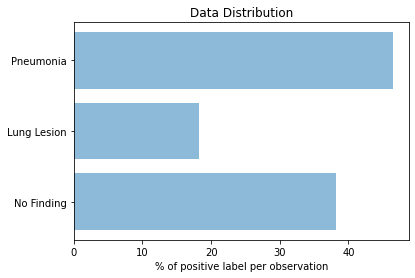

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
features_size=[]
features_data =[]
features_name=[]
#print(list(dtrain.columns[1:15]))
for feature in list(dtrain.columns[1:4]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)

objects = list(dtrain.columns[1:4])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100
# print(features_data)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')

In [28]:
### split data into train/valid/test
dtrain = dtrain.sample(frac=1)
dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size

dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

print(dtr.shape)
print(dv.shape)
print(dte.shape)

(35578, 4)
(4448, 4)
(4447, 4)


In [29]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

# target_size = (224,224)
#target_size = (299,299)
target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , 
                                                  x_col="Path", y_col=list(dtr.columns[1:3]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , 
                                                  x_col="Path", y_col=list(dv.columns[1:3]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=32)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , 
                                                x_col="Path", y_col=list(dte.columns[1:3]), 
                                                class_mode="other", 
                                                target_size=target_size, 
                                                shuffle = False, batch_size=1)

Found 35578 validated image filenames.
Found 4448 validated image filenames.
Found 4447 validated image filenames.


In [30]:
### model architecture design/selection
# create the base pre-trained model
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(2, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#print(model.summary())

In [31]:

### fit model 
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


#Tensorboard
log_dir = "logs/fit/train"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_H = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs,
                    callbacks=[tensorboard_callback])
# save model
model.save("model_DenseNet121_TF_Binary.h5")

Epoch 1/3
1111/1111 [==============================] - 829s 710ms/step - loss: 0.5635 - accuracy: 0.6409 - val_loss: 0.4950 - val_accuracy: 0.6178
Epoch 2/3
1111/1111 [==============================] - 602s 542ms/step - loss: 0.4928 - accuracy: 0.6371 - val_loss: 0.4939 - val_accuracy: 0.7003
Epoch 3/3
1111/1111 [==============================] - 545s 490ms/step - loss: 0.4801 - accuracy: 0.6510 - val_loss: 0.4988 - val_accuracy: 0.6012


In [ ]:
# load my trained model 
model_F = load_model('model_DenseNet121_TF_Binary.h5')
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
### prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:4],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:4])))

In [ ]:
score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)